$\#\#\#\#\#\#\#$ Libraries $\#\#\#\#\#\#\#$

In [37]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn import metrics
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE


import warnings

warnings.filterwarnings('ignore') 

$\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#$

# Data

In this exercise we want to make use of classifier models to predict if a plane has arrived late or not. The exercise asks us to make a new column that is 0 when the plane has been on time or earlier and 1 when it has been late.

We will load, another time, the data we have cleaned and added columns from the sprint 2 task 5. We need to notice, that in this case we already had (as we have seen in sprint 9 task 1 and 2) the binary column that indicates when a flight is late or earlier, see in table below column: DelayedArr. Thus this one column it is a categorical feature will be used as our "$y$" to prove our classifier models.

In [2]:
df = pd.read_csv('DelayedFlights_Mod.csv')

In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,VelocityAir,DelayedArr,TotalDelayed,TaxiTime
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,...,8.0,0.0,0.0,0.0,0.0,0.0,379.687500,0,0.0,12.0
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,...,10.0,0.0,0.0,0.0,0.0,0.0,379.687500,1,0.0,15.0
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,...,17.0,0.0,0.0,0.0,0.0,0.0,321.875000,1,0.0,20.0
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,...,10.0,2.0,0.0,0.0,0.0,32.0,343.333333,1,34.0,13.0
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,...,10.0,0.0,0.0,0.0,0.0,0.0,408.712871,1,0.0,14.0


We also encode the categorical variables that their type its object in numerical, with LabelEncoder() transformation, although as we had seen in 9.2 they are not meaniful to the analysis of the data posterior. But gives us sense of completness in the dataset having all in numerical.

In [5]:
encode = LabelEncoder()
df['UCarrier_en'] = encode.fit_transform(df['UniqueCarrier'])
df['TailNum_en'] = encode.fit_transform(df['TailNum'])
df['Origin_en'] = encode.fit_transform(df['Origin'])
df['Dest_en'] = encode.fit_transform(df['Dest'])

df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,SecurityDelay,LateAircraftDelay,VelocityAir,DelayedArr,TotalDelayed,TaxiTime,UCarrier_en,TailNum_en,Origin_en,Dest_en
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,...,0.0,0.0,379.687500,0,0.0,12.0,17,3756,135,284
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,...,0.0,0.0,379.687500,1,0.0,15.0,17,4116,135,284
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,...,0.0,0.0,321.875000,1,0.0,20.0,17,1948,140,48
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,...,0.0,32.0,343.333333,1,34.0,13.0,17,2129,140,48
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,...,0.0,0.0,408.712871,1,0.0,14.0,17,3839,140,149


We add the cyclial component on the dates of the dataset:

In [6]:
# Transforming data in cyclic for timestamp/timedate built-in functions. 
# we make use of the columns DepTime, CRSDepTime, ArrTime, CRSArrTime to know the hours for the date transformation.
# we can notice that afterwards we can drop these columns.
df['Year'] = 2008 # we add the column of year, previously erased, will be dropped afterwards.
df['DateDep'] = df.DepTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateCRSDep'] = df.CRSDepTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateArr'] = df.ArrTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateCRSArr'] = df.CRSArrTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000

df.tail()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,TaxiTime,UCarrier_en,TailNum_en,Origin_en,Dest_en,Year,DateDep,DateCRSDep,DateArr,DateCRSArr
1928363,12,13,6,1250.0,1220,1617.0,1552,DL,1621,N938DL,...,27.0,6,5088,199,18,2008,2.008121e+11,200812131220,2.008121e+11,200812131552
1928364,12,13,6,657.0,600,904.0,749,DL,1631,N3743H,...,49.0,6,1597,241,18,2008,2.008121e+11,200812130600,2.008121e+11,200812130749
1928365,12,13,6,1007.0,847,1149.0,1010,DL,1631,N909DA,...,40.0,6,4796,18,136,2008,2.008121e+11,200812130847,2.008121e+11,200812131010
1928366,12,13,6,1251.0,1240,1446.0,1437,DL,1639,N646DL,...,26.0,6,3293,135,18,2008,2.008121e+11,200812131240,2.008121e+11,200812131437
1928367,12,13,6,1110.0,1103,1413.0,1418,DL,1641,N908DL,...,19.0,6,4787,250,18,2008,2.008121e+11,200812131103,2.008121e+11,200812131418


Clean up the repeated columns:

In [7]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'VelocityAir', 'DelayedArr', 'TotalDelayed',
       'TaxiTime', 'UCarrier_en', 'TailNum_en', 'Origin_en', 'Dest_en', 'Year',
       'DateDep', 'DateCRSDep', 'DateArr', 'DateCRSArr'],
      dtype='object')

Remember that the feature DayOfWeek can be obtained again through converting any Date feature with the function: pd.Timestamp.day_of_week.

In [8]:
df.drop(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 
         'TailNum', 'Origin', 'Dest', 'Year'], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928368 entries, 0 to 1928367
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FlightNum          int64  
 1   ActualElapsedTime  float64
 2   CRSElapsedTime     float64
 3   AirTime            float64
 4   ArrDelay           float64
 5   DepDelay           float64
 6   Distance           int64  
 7   TaxiIn             float64
 8   TaxiOut            float64
 9   CarrierDelay       float64
 10  WeatherDelay       float64
 11  NASDelay           float64
 12  SecurityDelay      float64
 13  LateAircraftDelay  float64
 14  VelocityAir        float64
 15  DelayedArr         int64  
 16  TotalDelayed       float64
 17  TaxiTime           float64
 18  UCarrier_en        int64  
 19  TailNum_en         int64  
 20  Origin_en          int64  
 21  Dest_en            int64  
 22  DateDep            float64
 23  DateCRSDep         int64  
 24  DateArr            float64
 25  DateCRSArr        

Now, like on last sprint, we will draw the network to have a complete and easier graphical visualization of our data. 
The links are computed with Pearson's correlation and thresholded with the standard deviation of each variable (local threshold).

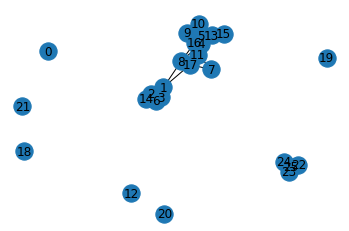

In [15]:
import networkx as nx
# 1. get adjacency matrix
corrdf = df.corr()
corrdfas = abs(corrdf)

# 2. Use a threshold to only keep the strongest links:
thres = corrdfas.std()
net = corrdf[(corrdf >= thres) & (corrdf != 1) ] # we don't want self links.
net[np.isnan(net)] = 0
net2 = np.array(net)

# 3. Map the network
G = nx.from_numpy_matrix(net2)

pos = nx.spring_layout(G)
nodes = nx.draw_networkx_labels(G, pos)

nx.draw(G, pos)
plt.show()

Small network (4 nodes: 22, 23, 24, 25): Date of Departure, Arrival and their CRS ones; the CRS are the times/schedules given by the central computer. They are independent of the delay occurred, thus not relevant for computing a delay, although they are dependent between themselves.

Large network (nodes: 1 to 11 and 13 to 17): ActualElapsedTime/CRS, AirTime, Arr/DepDelay, TaxiIn/Out/Time, Carrier/Weather/NAS/LateAircraft/Total, VelocityAir, DelayedArr. All this features are dependent, they also give us information on the delay as: time, type of delay, time/velocity of the flight or the driving towards the launch line or the gate.

Nodes that not are linked to either network: 0, 12, 18, 19, 20, 21. They correspond to the features: FlightNum, SecurityDelay, UniqueCarrier, TailNum, Origin, Destination. We have seen in sprint 9 that these columns are not relevant to determine the delay occurred on a flight. These features would be useful to include in the analysis if we were to ask, for example, which were the origin airports with more delays, or which companies are more prone to have delay, or even planes, and so on, then would add them to our analysis.

# Nivell 1

## Exercici 1: Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).


The exercise asks to do a new feature where the flights that are earlier/in time are categorized as 0, and the flights that are late are as 1. This is column DelayedArr, it was done in exercise 2.5, and included to the modified version of the dataset loaded in this exercise.

In [11]:
df.DelayedArr

0          0
1          1
2          1
3          1
4          1
          ..
1928363    1
1928364    1
1928365    1
1928366    1
1928367    0
Name: DelayedArr, Length: 1928368, dtype: int64

This will we the column that we will predict by using: DecisionTree, KNN, and, Suport Vector Machine. 

As we had seen in exercises 9.1 and 9.2, and in the network, above, the information of the delays comes given by the features: 

In [10]:
df2 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 
          'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir', 
          'DelayedArr', 'TotalDelayed']]

In [11]:
df2.columns

Index(['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir',
       'DelayedArr', 'TotalDelayed'],
      dtype='object')

In [12]:
df2.shape

(1928368, 15)

For exercise 3 we will need a subsample of the dataset for make the computations easier and more faster, the subsample needs to be consistent with the original dataset, thus we can make use of the function df.sample. 

In [13]:
# count the values on column DelayedArr:
df2.DelayedArr.value_counts() / len(df2)

1    0.907738
0    0.092262
Name: DelayedArr, dtype: float64

In [13]:
df2p = df2.sample(frac=0.60, random_state=42)

In [14]:
df2p.DelayedArr.value_counts() / len(df2p)

1    0.908011
0    0.091989
Name: DelayedArr, dtype: float64

In [16]:
df2p.shape

(1157021, 15)

In [17]:
df2p.DelayedArr.value_counts() / len(df2p) - df2.DelayedArr.value_counts() / len(df2)

1    0.000274
0   -0.000274
Name: DelayedArr, dtype: float64

We can see that the subsample will have a $0.03\%$ more of 1s respect the original, and $0.03\%$ of less 0s respect the original, we can see that the subsample is even enough, and thus we can use it instead of the original.

> Note: In notebook T10_02 (same folder [(1)][url1]) there is a power analysis for a random dataset of the size 100.

[url1]: https://github.com/isaura-o/ITAcademia/blob/main/Sprint10/T10_02_ChoosingTheRightSample.ipynb

Split the dataset into train/test[1]:

[1] On this first round we will not standarize, we will save for exercise 5 were we are asked to use further engineering, and then compare the results with the ones with the data not standanderized. Notice that all these features are numerical and none is categorical, the only categorical one is the one we want to predict.

We will also drop the feature ArrDelay, since it gives all the information on if a plane has been late or not, and we could see that if we mantained it the prediction will be exact.

In [15]:
# Define our X and y.
X = np.array(df2.drop(['ArrDelay','DelayedArr'], axis=1))
y = np.array(df2['DelayedArr']).reshape(-1,1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=y)

In [17]:
y_test.shape

(578511,)

Notice that now that our y is categorical, we can stratify our train/test sets.

**Decision Tree Classifier**

In [27]:
# Decision Tree Classifier
mDT = DecisionTreeClassifier(random_state=42)
mDT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
mDT.classes_

array([0, 1], dtype=int64)

In [29]:
np.round(mDT.feature_importances_,3)

array([0.287, 0.255, 0.009, 0.157, 0.011, 0.005, 0.013, 0.   , 0.   ,
       0.   , 0.   , 0.076, 0.186])

In [30]:
print('R^2 for train: ', mDT.score(X_train, y_train))
print('R^2 for test: ', mDT.score(X_test, y_test))

R^2 for train:  1.0
R^2 for test:  0.989042559259893


In [21]:
# prediction:
ypDT = mDT.predict(X_test)

In [22]:
df_DT = pd.DataFrame({'Real' : y_test, 'Predicted': ypDT})
df_DT.tail()

,Real,Predicted
578506,1,1
578507,1,1
578508,1,1
578509,1,1
578510,1,1


Accuracy:  0.989042559259893
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     53375
           1       0.99      0.99      0.99    525136

    accuracy                           0.99    578511
   macro avg       0.97      0.97      0.97    578511
weighted avg       0.99      0.99      0.99    578511



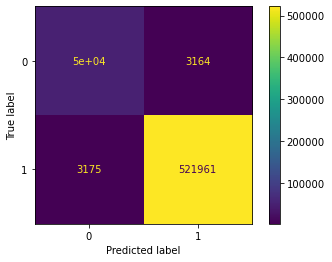

In [23]:
# accuracy, classification report, confusion_matrix
print('Accuracy: ',metrics.accuracy_score(y_test, ypDT))
print(metrics.classification_report(y_test, ypDT))
metrics.plot_confusion_matrix(mDT, X_test, y_test)
plt.show()

We can see that the accuracy is 0.99, the precision for negatives/in time/earlier is the same as the recall, 0.94, its 50000 flights on time as we can see in the confusion matrix, and the precision/recall for flights late is 0.99, confusion matrix shows there are 521961 flights that are computed as late. Also, we have misplaced a total of 6339 flights with this model, a total of $1\%$ of the values of the y_test set.


The below plot shows one of the wrongly inferred values, row number 532311.

In [ ]:
# we use to do this graph some entries:
df2DT = df_DT.sample(40)
df2DT.plot(kind='bar',figsize=(20,5))
plt.xlabel('row num')
plt.ylabel('Delayed or not')
plt.show()

**KNN**

In Nearest Neighbours Classifier function, the default parameter for neighbours is 5, but in this case we are using 3 neighbours, by doing that we expect the model predict worse, since it only compares it with the data of 3 rows instead of 5 rows, in exercise 3, we will see how the difference in this value allows better prediction of the data.

In [25]:
# KNearest Neighbors
mKNN = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
mKNN.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [26]:
print('R^2 for train: ', mKNN.score(X_train, y_train))
print('R^2 for test: ', mKNN.score(X_test, y_test))

R^2 for train:  0.9898922626618968
R^2 for test:  0.9766694151018736


In [27]:
# prediction:
ypKNN = mKNN.predict(X_test)

In [28]:
df_KNN = pd.DataFrame({'Real' : y_test, 'Predicted': ypKNN})
df_KNN.tail()

,Real,Predicted
578506,1,1
578507,1,1
578508,1,1
578509,1,1
578510,1,1


Accuracy:  0.9766694151018736
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     53375
           1       0.98      0.99      0.99    525136

    accuracy                           0.98    578511
   macro avg       0.94      0.92      0.93    578511
weighted avg       0.98      0.98      0.98    578511



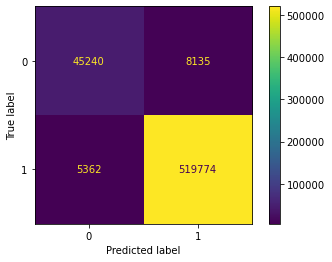

In [29]:
# accuracy, classification report, confusion_matrix
print('Accuracy: ',metrics.accuracy_score(y_test, ypKNN))
print(metrics.classification_report(y_test, ypKNN))
metrics.plot_confusion_matrix(mKNN, X_test, y_test)
plt.show()

This model, with n_neigbours=3, predicts worse than the Decision tree classifier. The accuracy obtained is 0.98, but the indexes of information retieval show that the model has problemes to correctly predict the flights on time/earlier (values that are 0). Precision/recall for flights on time/earlier is (0.89,0.85). Flights late have (0.98, 0.99) respectively, which means that we are able to infer them better compared with the on time/earlier.

In the heatmap below the table of information retieval indexes we see that now we have more false negatives and false positives (5362 and 8135, respectively), now we have a total of 13497 missplaced values, a $2\%$ of the values of the test set.

**Suport Vector Machine**

To run this model, first we wanted to know how long it took to run a sample of the set, after seeing that with kernel set at linear run smoothly, we choose that one over the default: 'rbf'. (See on T10_02 [1](https://github.com/isaura-o/ITAcademia/blob/main/Sprint10/T10_02_ChoosingTheRightSample.ipynb), how long takes samples of the data set to do the fitting.)

In [16]:
X_test.shape

(578511, 13)

In [17]:
y_test.shape

(578511,)

For proves (using a sample to see how long it takes to compute a 60% of the dataset):

In [57]:
# Define our X and y.
#X2 = np.array(df2p.drop(['ArrDelay','DelayedArr'], axis=1))
#y2 = np.array(df2p['DelayedArr']).reshape(-1,1)

In [58]:
#y2.shape

(1157021, 1)

In [59]:
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42, 
#                                                    shuffle=True, stratify=y2)

In [60]:
#y_test2.shape

(347107, 1)

It lasts around 67s, so we can use the whole dataset:

In [69]:
# Suport Vector Machine
import time
time0 = time.time()
mSVC = svm.SVC(kernel='linear',random_state=42)
mSVC.fit(X_train,y_train)
time1 = time.time()

print('time: ', time1 - time0)

time:  84.70866227149963


In [70]:
mSVC.dual_coef_

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -0.0103693 , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -0.06016772, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -0.1306473 , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.32026454,
        -1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  0.47749756,
         1.        ,  0.78078889,  0.2631624 ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

In [71]:
mSVC.fit_status_

0

In [72]:
mSVC.intercept_

array([9.95088794])

In [73]:
print('R^2 for train: ', mSVC.score(X_train, y_train))
print('R^2 for test: ', mSVC.score(X_test, y_test))

R^2 for train:  1.0
R^2 for test:  1.0


In [74]:
# prediction:
ypSVC = mSVC.predict(X_test)

In [75]:
df_SVC = pd.DataFrame({'Real' : y_test, 'Predicted': ypSVC})
df_SVC.tail()

,Real,Predicted
578506,1,1
578507,1,1
578508,1,1
578509,1,1
578510,1,1


Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53375
           1       1.00      1.00      1.00    525136

    accuracy                           1.00    578511
   macro avg       1.00      1.00      1.00    578511
weighted avg       1.00      1.00      1.00    578511



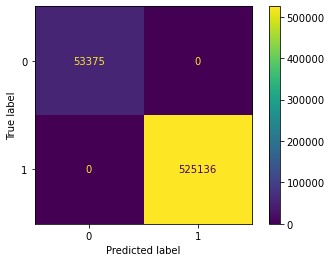

In [76]:
# accuracy, classification report, confusion_matrix
print('Accuracy: ',metrics.accuracy_score(y_test, ypSVC))
print(metrics.classification_report(y_test, ypSVC))
metrics.plot_confusion_matrix(mSVC, X_test, y_test)
plt.show()

This algorithm has been able to infer perfectly the late airplanes and the earlier/on time arrivals. We have got full scores on precision/recall/f1-score, also in the accuracy and determination coefficient.

## Exercici 2: Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.


In exercise 1 after running the models we have found their accuracy, classification report and confusion matrix. Here we will tabulate them to compare which ones are best, and percentages of true positives, true negatives, and the false positives and negatives.

Table:

$$\begin{array}{| c | c | c c c c || c | c | c | c | c |}
 &  \mbox{Accuracy} & \mbox{TP}(\%) & \mbox{FP} (\%) & \mbox{FN} (\%) & \mbox{TN} (\%)  & \mbox{Class}  & \mbox{Precision} & \mbox{Recall} & \mbox{F1-score} \\
\hline
\mbox{Decision Tree}  & 0.989 & 8.64 & 0.55 & 0.55 & 90.26 & 0 & 0.94 & 0.94 & 0.94 \\
 & &  &  &  &  & 1 & 0.99 & 0.99 & 0.99 \\
\hline
\mbox{KNN}& 0.980 & 7.82 & 0.92 & 1.41 & 89.85 & 0 & 0.89 & 0.85 & 0.87 \\
 & & & & & & 1 & 0.98 & 0.99 & 0.99 \\
\hline
\mbox{SVM} & 1 & 9.23 & 0 & 0 & 90.77 & 0 & 1 & 1 & 1 \\
 & &  & & & & 1 & 1 & 1 & 1 \\
\hline
\end{array}$$

The best classifier is SVM (SVClassifier), since fails less than the other two classifiers when tries to predict if the plane is earlier or not. The second best classifier is the Decision Tree, while the KNN is the less reliable.

## Exercici 3: Entrena’ls utilitzant els diferents paràmetres que admeten.

In this exercise we will modify the allowed parameters in the function: DecisionTreeClassifier, KNN, and, SVC.

**Decision Tree Classifier**

For the decision tree we will modify: criterion, splitter, max_depth, min_sample_split, min_sample_leaf, and, max_features.

In [50]:
# change criterion & splitter:
crit = {'gini', 'entropy'}
splite = {'best', 'random'}

MAEtrain_dt = []
MAEpre_dt = []

Strain_dt = []
Stest_dt = []

for i in crit:
    for j in splite:
        dt = DecisionTreeClassifier(criterion=i, splitter=j)
        dt.fit(X_train, y_train)
        
        ydt = dt.predict(X_train)
        MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        Strain_dt.append(dt.score(X_train, y_train))
        
        ypdt = dt.predict(X_test)
        MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))
        Stest_dt.append(dt.score(X_test, y_test))
        print(i,j, MAEtrain_dt, MAEpre_dt)

print('MAE train: ', MAEtrain_dt)
print('Score train: ', Strain_dt) 
print('MAE test: ', MAEpre_dt)
print('Score test: ', Stest_dt)


entropy best [0.0] [0.009189107899417643]
entropy random [0.0, 0.0] [0.009189107899417643, 0.014924521746345358]
gini best [0.0, 0.0, 0.0] [0.009189107899417643, 0.014924521746345358, 0.010871011960014589]
gini random [0.0, 0.0, 0.0, 0.0] [0.009189107899417643, 0.014924521746345358, 0.010871011960014589, 0.02031594904850556]
MAE train:  [0.0, 0.0, 0.0, 0.0]
Score train:  [1.0, 1.0, 1.0, 1.0]
MAE test:  [0.009189107899417643, 0.014924521746345358, 0.010871011960014589, 0.02031594904850556]
Score test:  [0.9908108921005824, 0.9850754782536546, 0.9891289880399854, 0.9796840509514945]


In [51]:
dftab = pd.DataFrame({'MAE train': MAEtrain_dt, 'MAE test': np.round(MAEpre_dt,3), 'Score Train' : Strain_dt, 
                      'Score test' : np.round(Stest_dt,3)},
                     index=['entropy/best', 'entropy/random', 'gini/best', 'gini/random'])
dftab

,MAE train,MAE test,Score Train,Score test
entropy/best,0.0,0.009,1.0,0.991
entropy/random,0.0,0.015,1.0,0.985
gini/best,0.0,0.011,1.0,0.989
gini/random,0.0,0.020,1.0,0.980


Since the MAE and the Scores on the train set are giving us perfect score, and no error, we will guide us with the test values. The best values of the test are when we use the parameters Entropy (for criterion) and Best (for splitter). Thus,instead of using the default we will use these other ones.

In [28]:
# change max_depth
depth = list(range(1,25+1))

MAEtrain_dt = []
MAEpre_dt = []

for i in depth:
        dt = DecisionTreeClassifier(random_state=42, max_depth=i)
        dt.fit(X_train, y_train)
        
        ydt = dt.predict(X_train)
        MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
        ypdt = dt.predict(X_test)
        MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))


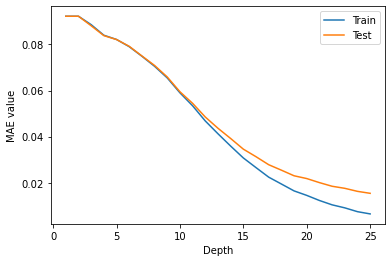

In [20]:
# plot the MAE vs the max_depth, for test and for train:
line1 = plt.plot(depth, MAEtrain_dt)
line2 = plt.plot(depth, MAEpre_dt)
plt.xlabel('Depth')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Mean Absolute Error decreases when we increase the depth, we will use max_depth = 25 to obtain less error at the prediction.

In [22]:
# change min_samples_split (0,1].

splot = np.linspace(0.1, 1, 10, endpoint=True)

MAEtrain_dt = []
MAEpre_dt = []

for i in splot:
    dt = DecisionTreeClassifier(random_state = 42, min_samples_split=i)
    dt.fit(X_train, y_train)
        
    ydt = dt.predict(X_train)
    MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
    ypdt = dt.predict(X_test)
    MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))

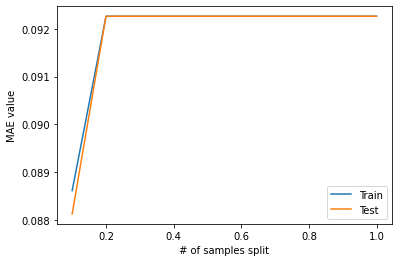

In [23]:
# plot the MAE vs the number of samples split, for test and for train:
line1 = plt.plot(splot, MAEtrain_dt)
line2 = plt.plot(splot, MAEpre_dt)
plt.xlabel('# of samples split')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Error increases as we increase the number of samples split, then we will use the default parameter.

In [24]:
# change min_samples_leaf (0, 0.5]

leaves = np.linspace(0.01,0.5,20, endpoint=True)

MAEtrain_dt = []
MAEpre_dt = []

for i in leaves:
    dt = DecisionTreeClassifier(random_state = 42, min_samples_leaf=i)
    dt.fit(X_train, y_train)
        
    ydt = dt.predict(X_train)
    MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
    ypdt = dt.predict(X_test)
    MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))

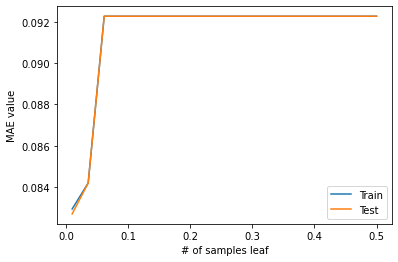

In [25]:
# plot the MAE vs the number of samples leaf, for test and for train:
line1 = plt.plot(leaves, MAEtrain_dt)
line2 = plt.plot(leaves, MAEpre_dt)
plt.xlabel('# of samples leaf')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Error increases as we increase the minum of samples in leaf, thus we will be using the default parameter.


In [26]:
# changing: max_features: we need at least 2 features to began a regression.

feats = list(range(2,X.shape[1]+1))

MAEtrain_dt = []
MAEpre_dt = []

for i in feats:
    dt = DecisionTreeClassifier(random_state = 42, max_features=i)
    dt.fit(X_train, y_train)
        
    ydt = dt.predict(X_train)
    MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
    ypdt = dt.predict(X_test)
    MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))

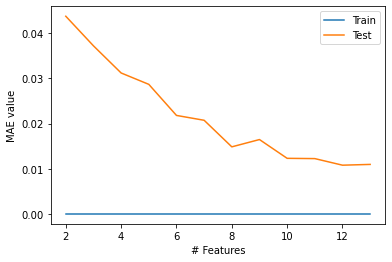

In [27]:
# plot the MAE vs the number of features, for test and for train:
line1 = plt.plot(feats, MAEtrain_dt)
line2 = plt.plot(feats, MAEpre_dt)
plt.xlabel('# Features')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Overall, increasing the number of features reduces error, although, we can see in this graph that adding some features may cause the error increase. We will use the maximum number of features.

In summary, for DecisionTreeClassifier we will use the parameters:

$$\begin{array}{| c | c | c | c | c | c |}
\hline
\mbox{Criterion} & \mbox{Splitter} & \mbox{max_depth} & \mbox{min samples split} & \mbox{min samples leaf} & \mbox{max_features} \\
\hline
\mbox{Entropy} & \mbox{Best} & 25 & \mbox{Default} & \mbox{Default} & \mbox{Default (all)} \\
\hline
\end{array}$$

**KNN**

In this algorithm we will change the parameters: number of neighbours, weights, algorithm, leaf size, and, the metric but only the power parameter.

In [35]:
# number of neighbors = 3 to 10

neigs = list(range(3,11))

MAEtrain_knn = []
MAEpre_knn = []

for i in neigs:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train, y_train)
        
    yknn = knn.predict(X_train)
    MAEtrain_knn.append(metrics.mean_absolute_error(y_train, yknn))
        
    ypknn = knn.predict(X_test)
    MAEpre_knn.append(metrics.mean_absolute_error(y_test, ypknn))
    


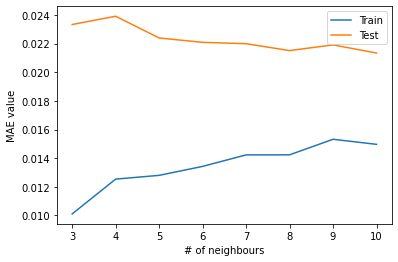

In [36]:
# plot the MAE vs the number of neighbours, for test and for train:
line1 = plt.plot(neigs, MAEtrain_knn)
line2 = plt.plot(neigs, MAEpre_knn)
plt.xlabel('# of neighbours')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

In the graph we see that the optimal number of neighbour is 5, the default parameter for the function. When we can also see that in train the error increases while we increase the number of neighbours, while for test the error decreases when we increase the number of neighbours.

In [24]:
# weights
weig = {'uniform', 'distance'}

MAEtrain_knn = []
MAEpre_knn = []

Strain_knn = []
Stest_knn = []

for i in weig:
    knn = KNeighborsClassifier(n_neighbors=5, weights=i,  n_jobs=-1)
    knn.fit(X_train, y_train)
        
    yknn = knn.predict(X_train)
    MAEtrain_knn.append(metrics.mean_absolute_error(y_train, yknn))
    Strain_knn.append(knn.score(X_train, y_train))
        
    ypknn = knn.predict(X_test)
    MAEpre_knn.append(metrics.mean_absolute_error(y_test, ypknn))
    Stest_knn.append(knn.score(X_test, y_test))
    
    print(i, MAEtrain_knn, MAEpre_knn)
        
print('MAE train: ', MAEtrain_knn)
print('Score train: ', Strain_knn) 
print('MAE test: ', MAEpre_knn)
print('Score test: ', Stest_knn)
        

uniform [0.012800615176274227] [0.022390239770721732]
distance [0.012800615176274227, 0.0] [0.022390239770721732, 0.021707452407992243]
MAE train:  [0.012800615176274227, 0.0]
Score train:  [0.9871993848237258, 1.0]
MAE test:  [0.022390239770721732, 0.021707452407992243]
Score test:  [0.9776097602292783, 0.9782925475920078]


In [25]:
dfw = pd.DataFrame({'MAE train': np.round(MAEtrain_knn,3), 'ScoreTrain' : np.round(Strain_knn,3), 
                    'MAE test': np.round(MAEpre_knn,4), 'Score test' : np.round(Stest_knn,4)}, 
                   index=['uniform', 'distance'])
dfw

,MAE train,ScoreTrain,MAE test,Score test
uniform,0.013,0.987,0.0224,0.9776
distance,0.000,1.000,0.0217,0.9783


In the table above we can see that the best results for train and test (we add another decimal to have more precision) are given by 'distance' parameter. 

> Note: We are not to use brute algorithm (see document T10_02 [1](https://github.com/isaura-o/ITAcademia/blob/main/Sprint10/T10_02_ChoosingTheRightSample.ipynb) for graphs), since time increases exponencial as we increase the system, the estimated time will had been: around $4\cdot 10^{25}$ seconds.

In [50]:
# to do this part, we first will take a subsample of the dataset df2p:
Xp = np.array(df2p.drop(['ArrDelay','DelayedArr'], axis=1))
yp = np.array(df2p['DelayedArr']).reshape(-1,1)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=yp)
Xp_train.shape

(539942, 13)

In [52]:
# algorithm:

algo = {'auto', 'ball_tree', 'kd_tree'}#, 'brute'}

MAEtrain_knn = []
MAEpre_knn = []

Strain_knn = []
Stest_knn = []

for i in algo:
    knn = KNeighborsClassifier(n_neighbors=5, algorithm=i,  n_jobs=-1)
    knn.fit(Xp_train, yp_train)
        
    yknn = knn.predict(Xp_train)
    MAEtrain_knn.append(metrics.mean_absolute_error(yp_train, yknn))
    Strain_knn.append(knn.score(Xp_train, yp_train))
        
    ypknn = knn.predict(Xp_test)
    MAEpre_knn.append(metrics.mean_absolute_error(yp_test, ypknn))
    Stest_knn.append(knn.score(Xp_test, yp_test))
    
    print(i, MAEtrain_knn, MAEpre_knn)
        
print('MAE train: ', MAEtrain_knn)
print('Score train: ', Strain_knn) 
print('MAE test: ', MAEpre_knn)
print('Score test: ', Stest_knn)

ball_tree [0.01630545503035511] [0.02806335213154426]
kd_tree [0.01630545503035511, 0.016301750928803465] [0.02806335213154426, 0.028041744992545536]
auto [0.01630545503035511, 0.016301750928803465, 0.016301750928803465] [0.02806335213154426, 0.028041744992545536, 0.028041744992545536]
MAE train:  [0.01630545503035511, 0.016301750928803465, 0.016301750928803465]
Score train:  [0.9836945449696449, 0.9836982490711965, 0.9836982490711965]
MAE test:  [0.02806335213154426, 0.028041744992545536, 0.028041744992545536]
Score test:  [0.9719366478684557, 0.9719582550074545, 0.9719582550074545]


In [54]:
dfalg = pd.DataFrame({'MAE train': MAEtrain_knn, 'ScoreTrain' : Strain_knn, 'MAE test': MAEpre_knn, 
                    'Score test' : Stest_knn}, index=['ball tree', 'kd tree', 'auto'])
dfalg

,MAE train,ScoreTrain,MAE test,Score test
ball tree,0.016305,0.983695,0.028063,0.971937
kd tree,0.016302,0.983698,0.028042,0.971958
auto,0.016302,0.983698,0.028042,0.971958


In the table we see that auto and kd_tree has the same values. We will use the default, auto, algorithm since it is faster than kd_tree.

In [17]:
# leaf size
leaf = list(range(1,21))

MAEtrain_knn = []
MAEpre_knn = []

for i in leaf:
    knn = KNeighborsClassifier(n_neighbors=5, leaf_size=i, n_jobs=-1)
    knn.fit(X_train, y_train)
        
    yknn = knn.predict(X_train)
    MAEtrain_knn.append(metrics.mean_absolute_error(y_train, yknn))
        
    ypknn = knn.predict(X_test)
    MAEpre_knn.append(metrics.mean_absolute_error(y_test, ypknn))
    #print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


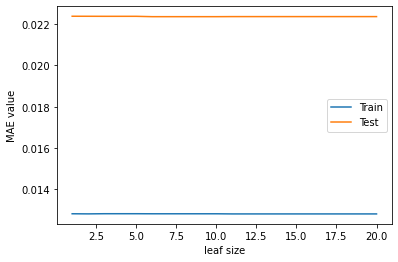

In [18]:
# plot the MAE vs the leaf size, for test and for train:
line1 = plt.plot(leaf, MAEtrain_knn)
line2 = plt.plot(leaf, MAEpre_knn)
plt.xlabel('leaf size')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

As we can see on the graph above, changing the leaf size it doesn't increase neither decrease the error, thus we will be using the default value for this parameter.

Another parameter to take into account it is the metric, in which the function accepts the following: Euclidian, Manhattan, Chebyshev, Minkowski, and others less common used. The function in default works with Minkowski metric, which is defined as: 

$$\mbox{distance} = \sum_{i=1}^{N}( |x_i-y_i|^p)^{(1/p)}$$

where p is the power parameter, when setting it to p=2, we obtain the euclidian metric, while p = 1 is the manhattan metric. 

In this system the best metric to compute distances will be the euclidian, thus we will use the default parameters for metric (Minkowski) and for power parameter (p=2).

In [34]:
# to do this exercise we have used the trained set and split it:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=y_train)

In [35]:
X_train2.shape

(944899, 13)

In [18]:
# power parameter, metric: Minkowski (default value)
p = [1,2]

MAEtrain_knn = []
MAEpre_knn = []

Strain_knn = []
Stest_knn = []

for i in p:
    knn = KNeighborsClassifier(n_neighbors=5, p=i, n_jobs=-1)
    knn.fit(X_train2, y_train2)
        
    yknn = knn.predict(X_train2)
    MAEtrain_knn.append(metrics.mean_absolute_error(y_train2, yknn))
    Strain_knn.append(knn.score(X_train2, y_train2))
        
    ypknn = knn.predict(X_test2)
    MAEpre_knn.append(metrics.mean_absolute_error(y_test2, ypknn))
    Stest_knn.append(knn.score(X_test2, y_test2))
    
    print(i)
    
print('MAE train: ', MAEtrain_knn)
print('Score train: ', Strain_knn) 
print('MAE test: ', MAEpre_knn)
print('Score test: ', Stest_knn)    

1
2
MAE train:  [0.016147757591022955, 0.013915773008543771]
Score train:  [0.9838522424089771, 0.9860842269914563]
MAE test:  [0.027768311775542155, 0.02382963171489389]
Score test:  [0.9722316882244578, 0.9761703682851061]


In [20]:
dfp = pd.DataFrame({'MAE train': np.round(MAEtrain_knn,3), 'ScoreTrain' : np.round(Strain_knn,3), 
                    'MAE test': np.round(MAEpre_knn,3), 'Score test' : np.round(Stest_knn,3)}, index=[1, 2])
dfp

,MAE train,ScoreTrain,MAE test,Score test
1,0.016,0.984,0.028,0.972
2,0.014,0.986,0.024,0.976


The best parameter to use in this case is p = 2, that is equivalent to the Minkowski metric with p = 2, i.e., the euclidian metric, as we expected.

In summary, for KNNClassifier we will use the default parameters for the function, since they are the ones who give us less mean absolute error and better score when computing the determination coefficient:

$$\begin{array}{| c | c | c | c | c |}
\hline
\mbox{Neighbours} & \mbox{Weights} & \mbox{algorithm} & \mbox{leaf size} & \mbox{power} \\
\hline
5 \mbox{ (Default)} & \mbox{Distance} & \mbox{auto (Default)} & \mbox{Default} & 2 \mbox{ (Default)} \\
\hline
\end{array}$$

**Suport Vector Machine**

In this model we will tweak the parameters: Regularization parameter (C), kernel, degree, 

In [92]:
# C parameter
cs = np.linspace(1,100,10, endpoint=True)

MAEtrain_svc = []
MAEpre_svc = []

for i in cs:

    mSVC = svm.SVC(kernel='linear', C=i, random_state=42)#, verbose=True)
    mSVC.fit(X_train,y_train)
    
    ysvc = mSVC.predict(X_train)
    MAEtrain_svc.append(metrics.mean_absolute_error(y_train, ysvc))
        
    ypsvc = mSVC.predict(X_test)
    MAEpre_svc.append(metrics.mean_absolute_error(y_test, ypsvc))

    
    print(i)

1.0
12.0
23.0
34.0
45.0
56.0
67.0
78.0
89.0
100.0


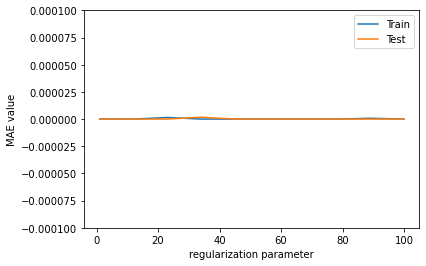

In [100]:
# plot the MAE vs the regularization parameter, for test and for train:
line1 = plt.plot(cs, MAEtrain_svc)
line2 = plt.plot(cs, MAEpre_svc)
plt.xlabel('regularization parameter')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.ylim(-1e-4,1e-4)
plt.show()

The mean absolute error when changing C, does not increase neither decrease, it is around 0, for train and test, thus we will mantain the default parameter.

In [21]:
# kernel
kern = {'linear'}

MAEtrain_svc = []
MAEpre_svc = []

Strain_svc = []
Stest_svc = []

for i in kern:

    mSVC = svm.SVC(kernel=i,random_state=42)#, verbose=True)
    mSVC.fit(X_train,y_train)
    
    ysvc = mSVC.predict(X_train)
    MAEtrain_svc.append(metrics.mean_absolute_error(y_train, ysvc))
    Strain_svc.append(mSVC.score(X_train, y_train))
        
    ypsvc = mSVC.predict(X_test)
    MAEpre_svc.append(metrics.mean_absolute_error(y_test, ypsvc))
    Stest_svc.append(mSVC.score(X_test, y_test))
    
    print(i)
    
print('MAE train: ', MAEtrain_svc)
print('Score train: ', Strain_svc) 
print('MAE test: ', MAEpre_svc)
print('Score test: ', Stest_svc)     
    

linear
MAE train:  [0.0]
Score train:  [1.0]
MAE test:  [0.0]
Score test:  [1.0]


Linear kernel shows zero on Mean Absolute error and the determination coefficient 1.

Let's see what happens with polynomial kernel, but before we need to shorten the dataset.

In [21]:
# Define our X and y from dataset 60%
X2 = np.array(df2p.drop(['ArrDelay','DelayedArr'], axis=1))
y2 = np.array(df2p['DelayedArr']).reshape(-1,1)

In [22]:
y2.shape

(1157021, 1)

In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=y2)

In [24]:
y_test2.shape

(347107, 1)

In [25]:
# degree and gamma (works with polynomial kernel)
polyno = [3, 4, 5]
gam = {'auto'}#, 'scale'}

MAEtrain_svc = []
MAEpre_svc = []

Strain_svc = []
Stest_svc = []

for i in polyno:
    for j in gam:

        mSVC = svm.SVC(kernel='poly', degree= i, gamma=j ,random_state=42, verbose=True)
        mSVC.fit(X_train2,y_train2)
    
        ysvc = mSVC.predict(X_train2)
        MAEtrain_svc.append(metrics.mean_absolute_error(y_train2, ysvc))
        Strain_svc.append(mSVC.score(X_train2, y_train2))
        
        ypsvc = mSVC.predict(X_test2)
        MAEpre_svc.append(metrics.mean_absolute_error(y_test2, ypsvc))
        Stest_svc.append(mSVC.score(X_test2, y_test2))
    
        print(i,j)
    
print('MAE train: ', MAEtrain_svc)
print('Score train: ', Strain_svc) 
print('MAE test: ', MAEpre_svc)
print('Score test: ', Stest_svc)

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

*.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................*...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

...............................................................................................................................................................................................................................................................................................................................................................................................*
optimization finished, #iter = 869689290
obj = -0.000000, rho = 0.850854
nSV = 42, nBSV = 0
Total nSV = 42
5 auto
MAE train:  [4.938795970930247e-06, 7.408193956395371e-06, 7.408193956395371e-06]
Score train:  [0.999995061204029, 0.9999925918060436, 0.9999925918060436]
MAE test:  [1.4404780082222484e-05, 2.016669211511148e-05, 4.033338423022296e-05]
Score test:  [0.9999855952199178, 0.9999798333078849, 0.9999596666157697]


In [38]:
dfpol = pd.DataFrame({'MAE train': np.round(MAEtrain_svc,6), 'ScoreTrain' : np.round(Strain_svc,6), 
                    'MAE test': np.round(MAEpre_svc,6), 'Score test' : np.round(Stest_svc,6)}, index=[3, 4, 5])
dfpol

,MAE train,ScoreTrain,MAE test,Score test
3,0.000005,0.999995,0.000014,0.999986
4,0.000007,0.999993,0.000020,0.999980
5,0.000007,0.999993,0.000040,0.999960


Even though the good inferred results the polynomial kernel might not be a good choice since we might be overfitting the dataset. Even more, the number of iterations done to optimize the system and find a solution, of each degree (3, 4, 5), when gamma is auto, is around $10^8$ iterations for the $60\%$ of the original dataset. Similary happens for rbf and sigmoid, for this system the polynomial, rbf, and, sigmoid kernels are not adequate to make predictions. 

Although, we need take a really small sample of the dataset and since we know from the proves done in notebook T10_02 [1](https://github.com/isaura-o/ITAcademia/blob/main/Sprint10/T10_02_ChoosingTheRightSample.ipynb), that the time that takes to the model with certain kernels to find the optimum solution is practically linear for small datasets, but has exponencial growth in time when the dataset is over 100000 entries (points).

So, we choose a sample of the $1\%$ of our data, which will not give us an understanding of the system since it is too small, but will allow us to compare more easily all the kernels that are avaible for this model.

In [18]:
# use the test set since it is a 1% of the dataset:
df20 = df2.sample(frac=0.01)
Xp = np.array(df20.drop(['ArrDelay','DelayedArr'], axis=1))
yp = np.array(df20['DelayedArr']).reshape(-1,1)

Xp_train2, Xp_test2, yp_train2, yp_test2 = train_test_split(Xp, yp.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=yp)

print(Xp_train2.shape, yp_train2.shape, Xp_test2.shape, yp_test2.shape)

(13498, 13) (13498,) (5786, 13) (5786,)


In [21]:
# kernels, degree, and, gamma
algo = {'linear', 'poly', 'rbf', 'sigmoid'}
gam = {'scale', 'auto'}
n = [3, 4, 5]

MAEtrain_svc = []
MAEpre_svc = []

Strain_svc = []
Stest_svc = []

for i in algo:
    if i == 'poly':
        for j in n:
            for k in gam:
                print(i,j,k)
                
                mSVC = svm.SVC(kernel=i, degree=j, gamma=k ,random_state=42)
                mSVC.fit(Xp_train2,yp_train2)
    
                ysvc = mSVC.predict(Xp_train2)
                MAEtrain_svc.append(metrics.mean_absolute_error(yp_train2, ysvc))
                Strain_svc.append(mSVC.score(Xp_train2, yp_train2))
        
                ypsvc = mSVC.predict(Xp_test2)
                MAEpre_svc.append(metrics.mean_absolute_error(yp_test2, ypsvc))
                Stest_svc.append(mSVC.score(Xp_test2, yp_test2))
    
                print(i, j, k, MAEtrain_svc, MAEpre_svc)
    
    elif (i == 'rbf') | (i == 'sigmoid' ):
        for j in gam:
            print(i,j)
            
            mSVC = svm.SVC(kernel=i, gamma=j ,random_state=42)
            mSVC.fit(Xp_train2,yp_train2)
    
            ysvc = mSVC.predict(Xp_train2)
            MAEtrain_svc.append(metrics.mean_absolute_error(yp_train2, ysvc))
            Strain_svc.append(mSVC.score(Xp_train2, yp_train2))
        
            ypsvc = mSVC.predict(Xp_test2)
            MAEpre_svc.append(metrics.mean_absolute_error(yp_test2, ypsvc))
            Stest_svc.append(mSVC.score(Xp_test2, yp_test2))
    
            print(i,j, MAEtrain_svc, MAEpre_svc)
        
    elif (i == 'linear') :
        print(i)
        
        mSVC = svm.SVC(kernel=i, random_state=42)
        mSVC.fit(Xp_train2,yp_train2)
    
        ysvc = mSVC.predict(Xp_train2)
        MAEtrain_svc.append(metrics.mean_absolute_error(yp_train2, ysvc))
        Strain_svc.append(mSVC.score(Xp_train2, yp_train2))
        
        ypsvc = mSVC.predict(Xp_test2)
        MAEpre_svc.append(metrics.mean_absolute_error(yp_test2, ypsvc))
        Stest_svc.append(mSVC.score(Xp_test2, yp_test2))
    
        print(i, MAEtrain_svc, MAEpre_svc)
    
print('MAE train: ', MAEtrain_svc)
print('Score train: ', Strain_svc) 
print('MAE test: ', MAEpre_svc)
print('Score test: ', Stest_svc)

linear
linear [0.0] [0.0]
sigmoid scale
sigmoid scale [0.0, 0.14720699362868572] [0.0, 0.14258555133079848]
sigmoid auto
sigmoid auto [0.0, 0.14720699362868572, 0.0920877166987702] [0.0, 0.14258555133079848, 0.09211890770826132]
rbf scale
rbf scale [0.0, 0.14720699362868572, 0.0920877166987702, 0.0920877166987702] [0.0, 0.14258555133079848, 0.09211890770826132, 0.09211890770826132]
rbf auto
rbf auto [0.0, 0.14720699362868572, 0.0920877166987702, 0.0920877166987702, 0.00022225514891094977] [0.0, 0.14258555133079848, 0.09211890770826132, 0.09211890770826132, 0.09194607673695127]
poly 3 scale
poly 3 scale [0.0, 0.14720699362868572, 0.0920877166987702, 0.0920877166987702, 0.00022225514891094977, 0.07586309082827085] [0.0, 0.14258555133079848, 0.09211890770826132, 0.09211890770826132, 0.09194607673695127, 0.07449014863463532]
poly 3 auto
poly 3 auto [0.0, 0.14720699362868572, 0.0920877166987702, 0.0920877166987702, 0.00022225514891094977, 0.07586309082827085, 0.0] [0.0, 0.14258555133079848,

In [22]:
dfker = pd.DataFrame({'MAE train': np.round(MAEtrain_svc,6), 'ScoreTrain' : np.round(Strain_svc,6), 
                    'MAE test': np.round(MAEpre_svc,6), 'Score test' : np.round(Stest_svc,6)}, 
                     index=['linear', 'sigmoid scale', 'sigmoid auto', 'rbf scale', 'rbf auto', 'poly 3 scale', 
                           'poly 3 auto', 'poly 4 scale', 'poly 4 auto', 'poly 5 scale', 'poly 5 auto'])
dfker

,MAE train,ScoreTrain,MAE test,Score test
linear,0.000000,1.000000,0.000000,1.000000
sigmoid scale,0.147207,0.852793,0.142586,0.857414
sigmoid auto,0.092088,0.907912,0.092119,0.907881
rbf scale,0.092088,0.907912,0.092119,0.907881
rbf auto,0.000222,0.999778,0.091946,0.908054
poly 3 scale,0.075863,0.924137,0.074490,0.925510
poly 3 auto,0.000000,1.000000,0.000518,0.999482
poly 4 scale,0.070381,0.929619,0.068095,0.931905
poly 4 auto,0.000296,0.999704,0.000864,0.999136
poly 5 scale,0.065343,0.934657,0.061528,0.938472


We can see in the table above that the best kernel to use is linear followed by polynimial in degree 3 with gamma in automatic. While the worse kernel is sigmoid with gamma scale. We will choose the parameter kernel = linear, either for best fit and prediction, and for being less computational expensive.

The high values obtained in the sigmoid, rbf, and, poly degree 5, all them with gamma set on scale might be because of the low resolution of the dataset we have choose, remember that the dataset it is only $1\%$ of the original, with 13498 points for train and 5786 for test. We have seen that for polynomial with degrees 3, 4, and, 5 gamma in auto the MAE obtained in train and test were zeros with $10^{-6}$ of precision, now for the same with degrees 4 and 5 they are around $3 \cdot 10^{-4}$, thus the error has increased, also has decreased the score of the model, means that there is not enough data to correctly infer if a plane has been late or not, as we had when we did run them with the $60\%$ of the dataset.


In [86]:
# tolerance
tola = [0.1, 0.01, 1e-3, 1e-4, 1e-5]

MAEtrain_svc = []
MAEpre_svc = []

for i in tola:

    mSVC = svm.SVC(kernel='linear', tol=i,random_state=42)#, verbose=True)
    mSVC.fit(X_train,y_train)
    
    ysvc = mSVC.predict(X_train)
    MAEtrain_svc.append(metrics.mean_absolute_error(y_train, ysvc))
        
    ypsvc = mSVC.predict(X_test)
    MAEpre_svc.append(metrics.mean_absolute_error(y_test, ypsvc))

    
    print(i)


0.1
0.01
0.001
0.0001
1e-05


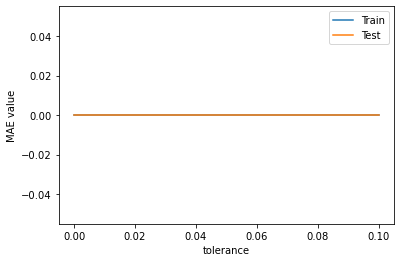

In [88]:
# plot the MAE vs the tolerance, for test and for train:
line1 = plt.plot(tola, MAEtrain_svc)
line2 = plt.plot(tola, MAEpre_svc)
plt.xlabel('tolerance')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

There is no incraese or decresase of the error made when we change the tolerance, the mean absolute error is zero (for linear kernel).

**Summary**


For computation time, since we are interested on exploring all the dataset we will be using the linear kernel. Which leaves on default all the options related to the other kernels. Also, we have seen that there is no difference into changing the regularization parameter, either the tolarence, so the parameters we will use are:

$$\begin{array}{| c | c | c | c | c |}
\hline
\mbox{Regularization (C)} & \mbox{Kernel} & \mbox{Tolerance}  \\
\hline
1 \mbox{ (Default)} & \mbox{Linear} & 1\cdot 10^{-3} \mbox{(Default)} \\
\hline
\end{array}$$

## Exercici 4: Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

**External Cross-validation**

The external cross-validation it is done determining the determination coefficient ($R^2$) for train and test sets, as we have done in exercise 1. In this case we will make use of the parameters obtained on the analysis of exercise 3.

In [22]:
# Decision Tree Classifier
cmDT = DecisionTreeClassifier(criterion='entropy', max_depth=25, random_state=42)
cmDT.fit(X_train, y_train)

print('R^2 for train: ', cmDT.score(X_train, y_train))
print('R^2 for test: ', cmDT.score(X_test, y_test))

R^2 for train:  0.9869682492293628
R^2 for test:  0.9803270810753815


Setting the criterion entropy and a maximum value for the depth, has made the determination coefficient decresase. From the exercise above we know that changing the criterion to entropy decreases consistently the mean absolute error on the system, while setting a fixed value on max_depth = 25 the mean absolute error is around 0.02, the decrease on the score coefficients it is likely to be due to this last parameter.

In [23]:
# KNeighbours Classifier
cmKN = KNeighborsClassifier(n_neighbors=5, weights='distance',  n_jobs=-1)
cmKN.fit(X_train, y_train)

print('R^2 for train: ', cmKN.score(X_train, y_train))
print('R^2 for test: ', cmKN.score(X_test, y_test))

R^2 for train:  1.0
R^2 for test:  0.9782925475920078


The model obtains better determination coefficients when the weights are changed from uniform to distance. The increase is around 0.01 in both cases. 

The weights in distance means that instead of weighting equally all the neighours on the neighbourhood, now we use as weight the inverse of the distance. I.e., the nodes that are closer to a certain will influence more than the nodes that are far from the node we want to determine. This is also a more realistic approach if we are looking at physical systems, i.e., for example in earthquakes, the decrease of strenght is around $1/d^2$ as we move away from the source. 

In [23]:
# Suport Vector Machine Classifier
cmSV = svm.SVC(kernel='linear', random_state=42)
cmSV.fit(X_train, y_train)

print('R^2 for train: ', cmSV.score(X_train, y_train))
print('R^2 for test: ', cmSV.score(X_test, y_test))

R^2 for train:  1.0
R^2 for test:  1.0


We obtain the same scores as we got when we run it, since we are using the same kernel.

Setting it all together, without parameters and with parameters tweaked (columns with new):

**Table of determination coefficients for External cross-validation**

$$\begin{array}{| c | c | c | c | c |}
\hline
 & R^2\mbox{ Train} & R^2\mbox{ Test} & R^2\mbox{ Train new} & R^2\mbox{ Test new}  \\
\hline
\mbox{Decision Tree Classifier} & 1 & 0.989 & 0.987 & 0.980 \\
\mbox{KNeighours Classifier} & 0.990 & 0.977 & 1 & 0.978\\
\mbox{Suport Vector Classifier} & 1 & 1 & 1 & 1 \\
\hline
\end{array}$$

**Internal Cross-validation**

In [24]:
# cross-validation DTC with cv=5 (five-fold standard)
cvDT = cross_validate(cmDT, X, y, n_jobs=-1)
print('keys DT:{}'.format(sorted(cvDT.keys())))
print('test scores DT: {}'.format(cvDT['test_score']))

keys DT:['fit_time', 'score_time', 'test_score']
test scores DT: [0.98228815 0.98083096 0.97986901 0.97854659 0.98138838]


Overall the values obtained with the internal cross-validation are slightly higher, the first, the second, and the last, than the ones obtained in the external cross-validation. In the third and fourth the is a slight decrease on the determination coefficient. 

In [26]:
# cross-validation DTC with cv=5 (five-fold standard)
cvKN = cross_validate(cmKN, X, y.ravel(), n_jobs=-1)
print('keys DT:{}'.format(sorted(cvKN.keys())))
print('test scores DT: {}'.format(cvKN['test_score']))

keys DT:['fit_time', 'score_time', 'test_score']
test scores DT: [0.97811105 0.97898484 0.97778175 0.97737462 0.97837287]


Overall the values had slightly decreased, only the scores obtained on the second and last subset were slighlty higher than the ones obtained in the external cross-validation.

In [25]:
# cross-validation SVC with cv=5 (five-fold standard)
cvSV = cross_validate(cmSV, X, y.ravel(), n_jobs=-1)
print('keys DT:{}'.format(sorted(cvSV.keys())))
print('test scores DT: {}'.format(cvSV['test_score']))

keys DT:['fit_time', 'score_time', 'test_score']
test scores DT: [1. 1. 1. 1. 1.]


The scores of each test subset is the same as for the whole dataset. The model is able to predict it perfectly.

Setting it all together, with parameters tweaked comparing internal with external:

**Table of determination coefficients for External cross-validation and Internal cross-validation**

$$\begin{array}{| c | c | c | c | c |}
\hline
 & R^2\mbox{ Test External} & R^2\mbox{ Test Internal 1} &  R^2\mbox{ Test Internal 2} & R^2\mbox{ Test Internal 3} &  R^2\mbox{ Test Internal 4} & R^2\mbox{ Test Internal 5}   \\
\hline
\mbox{Decision Tree Classifier} &  0.980 & 0.982 & 0.981 & 0.978 & 0.979 & 0.981 \\
\mbox{KNeighours Classifier} & 0.978 & 0.978 & 0.979 & 0.978 & 0.977 & 0.978 \\
\mbox{Suport Vector Classifier} &  1 & 1 & 1 & 1 & 1 & 1 \\
\hline
\end{array}$$

# Nivell 2

## Exercici 5: Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

The engineering processes used in this exercise are the scaling of the data and balancing the data on the dataset. In both cases we will see how this processes behave to then use them on the exercise 6.

First, we will use standardescaler and robustscaler and see how they behave with the classifier Decision Tree, since its determination coefficient it is not 1, and it is the fastest one.

In [28]:
#1. Define our X and y.
X = np.array(df2.drop(['ArrDelay','DelayedArr'], axis=1))
y = np.array(df2['DelayedArr']).reshape(-1,1)

#2. Use standard Scaler:
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X)

#3. Use Robust Scaler:
scaler2 = RobustScaler()
X_scaled2 = scaler2.fit_transform(X)

In [30]:
# use robustscaler
X2a_train, X2a_test, y2a_train, y2a_test = train_test_split(X_scaled, y.ravel(), 
                                                        test_size=0.3, random_state=42, shuffle=True)
X2b_train, X2b_test, y2b_train, y2b_test = train_test_split(X_scaled2, y.ravel(), 
                                                        test_size=0.3, random_state=42, shuffle=True)


In [33]:
# we see how they behave with the classifier decision Tree
mDT = DecisionTreeClassifier(criterion='entropy', max_depth=25, random_state=42)
mDT.fit(X2a_train, y2a_train)

y2apred = mDT.predict(X2a_test)
print('Determination coefficient train Scaled: ', mDT.score(X2a_train,y2a_train))
print('Determination coefficient test Scaled: ', mDT.score(X2a_test,y2a_test))
print('Mean Squared Error Scaled: ', metrics.mean_squared_error(y2a_test, y2apred))
print('Mean Absolute Error Scaled: ', metrics.mean_absolute_error(y2a_test, y2apred))
print('\n')

# RobustScaled:
mDT2 = DecisionTreeClassifier(criterion='entropy', max_depth=25, random_state=42)
mDT2.fit(X2b_train, y2b_train)

y2bpred = mDT2.predict(X2b_test)
print('Determination coefficient train Robust: ', mDT2.score(X2b_train,y2b_train))
print('Determination coefficient test Robust: ', mDT2.score(X2b_test,y2b_test))
print('Mean Squared Error Robust: ', metrics.mean_squared_error(y2b_test, y2bpred))
print('Mean Absolute Error Robust: ', metrics.mean_absolute_error(y2b_test, y2bpred))
print('\n')

print('DeterminationCoefficient train difference:', abs(mDT.score(X2a_train,y2a_train) - mDT2.score(X2b_train,y2b_train)))
print('DeterminationCoefficient test difference:', abs(mDT.score(X2a_test,y2a_test)- mDT2.score(X2b_test,y2b_test)))
print('MeanSquaredError difference:', abs(metrics.mean_squared_error(y2a_test, y2apred) - metrics.mean_squared_error(y2b_test, y2bpred)))
print('MeanAbsolutError difference:', abs( metrics.mean_absolute_error(y2a_test, y2apred) - metrics.mean_absolute_error(y2b_test, y2bpred)))


Determination coefficient train Scaled:  0.9881639314386635
Determination coefficient test Scaled:  0.9812259403883418
Mean Squared Error Scaled:  0.018774059611658206
Mean Absolute Error Scaled:  0.018774059611658206


Determination coefficient train Robust:  0.9881639314386635
Determination coefficient test Robust:  0.9812311261151473
Mean Squared Error Robust:  0.018768873884852665
Mean Absolute Error Robust:  0.018768873884852665


DeterminationCoefficient train difference: 0.0
DeterminationCoefficient test difference: 5.185726805523316e-06
MeanSquaredError difference: 5.1857268055406636e-06
MeanAbsolutError difference: 5.1857268055406636e-06


Let's tabulate this results for better comparision.

$$\begin{array}{| c | c | c | c |}
\hline
 &\mbox{Standard} & \mbox{Robust} & \mbox{ Differences} \\
\hline
R^2 \mbox{Train} & 0.988 & 0.988 & 0 \\
R^2 \mbox{Test} & 0.981 & 0.981 & 5.186 \cdot 10^{-6} \\
\mbox{MAE Train} & 0.019 & 0.019 & 5.186 \cdot 10^{-6}  \\
\mbox{MAE Test} & 0.019 & 0.019 & 5.186 \cdot 10^{-6} \\
\hline
\end{array}$$

We can see that there is no difference between using standard scaler or robust, so we will use standard scaler, for the balancing of the data.

Since our dataset is heavily imbalanced on the late/on time arrivals:

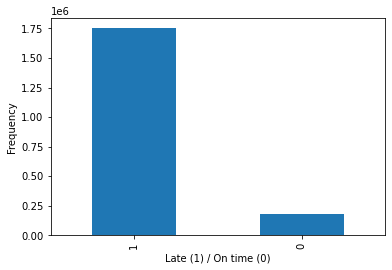

In [35]:
df2['DelayedArr'].value_counts().plot.bar()
plt.xlabel('Late (1) / On time (0)')
plt.ylabel('Frequency')
plt.show()

Next, we will make use of the function SMOTE to balance the dataset scaled with Standard Scaler.

In [39]:
# use SMOTE to balance the dataset.

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X2a_train, y2a_train)

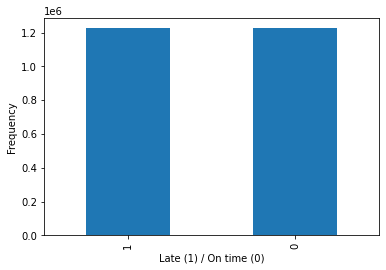

In [41]:
# show the new data:
pd.Series(y_train_sm).value_counts().plot.bar()
plt.xlabel('Late (1) / On time (0)')
plt.ylabel('Frequency')
plt.show()

accuracy test: 0.9660853466917656
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     53250
           1       0.99      0.97      0.98    525261

    accuracy                           0.97    578511
   macro avg       0.88      0.93      0.90    578511
weighted avg       0.97      0.97      0.97    578511



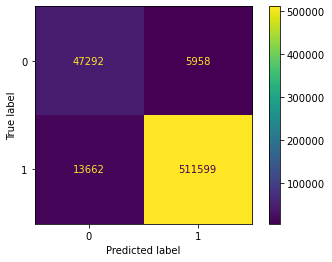

In [46]:
# fit
mDT.fit(X_train_sm, y_train_sm)

# predict:
Xtrainpred_sm = mDT.predict(X_train_sm)
ypred_sm = mDT.predict(X2a_test)

#show the accuracy scores to see how good it is now the predictions:
#print('accuracy train:', metrics.accuracy_score(Xtrainpred_sm, y_train_sm))
print('accuracy test:', metrics.accuracy_score(y2a_test, ypred_sm))

print(metrics.classification_report(y2a_test, ypred_sm))

metrics.plot_confusion_matrix(mDT, X2a_test, y2a_test)
plt.show()

Let's compare with the results from exercise 1/2, the imbalanced dataset:

$$\begin{array}{| c | c | c c c c || c | c | c | c | c |}
 &  \mbox{Accuracy} & \mbox{TP}(\%) & \mbox{FP} (\%) & \mbox{FN} (\%) & \mbox{TN} (\%)  & \mbox{Class}  & \mbox{Precision} & \mbox{Recall} & \mbox{F1-score} \\
\hline
\mbox{Decision Tree Imbalanced}  & 0.989 & 8.64 & 0.55 & 0.55 & 90.26 & 0 & 0.94 & 0.94 & 0.94 \\
 & &  &  &  &  & 1 & 0.99 & 0.99 & 0.99 \\
\hline
\mbox{Decision Tree Balanced}& 0.966 & 8.17 & 1.03 & 2.36 & 88.44 & 0 & 0.78 & 0.89 & 0.83 \\
 & & & & & & 1 & 0.99 & 0.97 & 0.98 \\
\hline
\end{array}$$


Balancing the dataset has increased the false positives and false negatives, also it has decreased the information retrival indexes (precision, recall and f1-score). 

Since this engineering has not made the prediction better, it had worse, we will not use it on the exercise 6.

# Nivell 3

## Exercici 6: No utilitzis la variable DepDelay a l’hora de fer prediccions

We drop ArrDelay and DepDelay feature from our dataset initial:

In [47]:
df4 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 
          'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir', 'DelayedArr', 'TotalDelayed']]
df4.columns

Index(['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn',
       'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'LateAircraftDelay', 'VelocityAir', 'DelayedArr', 'TotalDelayed'],
      dtype='object')

In [48]:
# split in X and y
X = np.array(df4.drop(['DelayedArr'], axis=1))
y = np.array(df4['DelayedArr']).reshape(-1,1)

In [49]:
# use robustscaler in X
scaler2 = RobustScaler()
X_scaled = scaler2.fit_transform(X)

In [50]:
# split train/test
X4_train, X4_test, y4_train, y4_test = train_test_split(X_scaled, y.ravel(), test_size=0.3, random_state=42, 
                                                        shuffle=True, stratify = y)

**Decision Tree Classifier**

In [53]:
mDT = DecisionTreeClassifier(criterion='entropy', random_state=42)
mDT.fit(X4_train, y4_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [55]:
y4pred = mDT.predict(X4_test)

print('Determination coefficient train: ', mDT.score(X4_train,y4_train))
print('Determination coefficient test: ', mDT.score(X4_test,y4_test))
print('Mean Squared Error: ', metrics.mean_squared_error(y4_test, y4pred))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y4_test, y4pred))

Determination coefficient train:  0.9968515183460174
Determination coefficient test:  0.9129351040861798
Mean Squared Error:  0.08706489591382013
Mean Absolute Error:  0.08706489591382013


accuracy test: 0.9129351040861798
              precision    recall  f1-score   support

           0       0.53      0.54      0.53     53250
           1       0.95      0.95      0.95    525261

    accuracy                           0.91    578511
   macro avg       0.74      0.75      0.74    578511
weighted avg       0.91      0.91      0.91    578511



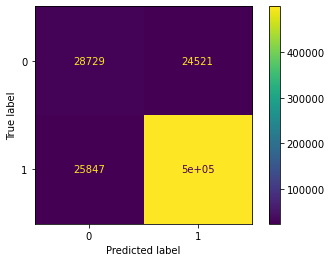

In [56]:
print('accuracy test:', metrics.accuracy_score(y4_test, y4pred))

print(metrics.classification_report(y4_test, y4pred))

metrics.plot_confusion_matrix(mDT, X4_test, y4_test)
plt.show()

The false positives and negatives had increased quantetively respect when we used the column DepDelay, means that the model cannot infer if the flight is on time/earlier or late as well it was able when we were using that last column as we can see that reflected on the precision/recall/f1-score indexes. The predicted earlier/on time flights the information retevial indexes seem to point that they had been inferred randomly.

$$\begin{array}{| c | c | c c c c || c | c | c | c | c |}
 &  \mbox{Accuracy} & \mbox{TP}(\%) & \mbox{FP} (\%) & \mbox{FN} (\%) & \mbox{TN} (\%)  & \mbox{Class}  & \mbox{Precision} & \mbox{Recall} & \mbox{F1-score} \\
\hline
\mbox{Decision Tree}  & 0.913 & 4.96 & 4.24 & 4.46 & 86.34 & 0 & 0.53 & 0.54 & 0.53 \\
 & &  &  &  &  & 1 & 0.95 & 0.95 & 0.95 \\
\hline
\end{array}$$

**KNN**

In [59]:
mKN = KNeighborsClassifier(n_neighbors=5, weights='distance',  n_jobs=-1)
mKN.fit(X4_train, y4_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [60]:
y4predKN = mKN.predict(X4_test)

print('Determination coefficient train: ', mKN.score(X4_train,y4_train))
print('Determination coefficient test: ', mKN.score(X4_test,y4_test))
print('Mean Squared Error: ', metrics.mean_squared_error(y4_test, y4predKN))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y4_test, y4predKN))

Determination coefficient train:  0.9968492958883793
Determination coefficient test:  0.9188779470053292
Mean Squared Error:  0.0811220529946708
Mean Absolute Error:  0.0811220529946708


accuracy test: 0.9188779470053292
              precision    recall  f1-score   support

           0       0.57      0.48      0.52     53250
           1       0.95      0.96      0.96    525261

    accuracy                           0.92    578511
   macro avg       0.76      0.72      0.74    578511
weighted avg       0.91      0.92      0.92    578511



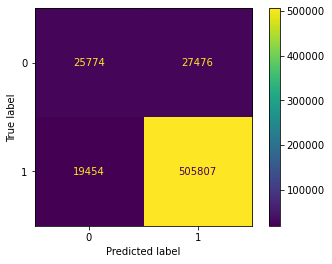

In [62]:
print('accuracy test:', metrics.accuracy_score(y4_test, y4predKN))

print(metrics.classification_report(y4_test, y4predKN))

metrics.plot_confusion_matrix(mKN, X4_test, y4_test)
plt.show()

As the last model, this one also seems to randomly predict the earlier arrival of a plane, as we can see in the values of precision/recall/f1-score. Even more, the recall is under 0.5, which can be an indication that we have predicted more false positives than correct true positives, the table below so shows:

$$\begin{array}{| c | c | c c c c || c | c | c | c | c |}
 &  \mbox{Accuracy} & \mbox{TP}(\%) & \mbox{FP} (\%) & \mbox{FN} (\%) & \mbox{TN} (\%)  & \mbox{Class}  & \mbox{Precision} & \mbox{Recall} & \mbox{F1-score} \\
\hline
\mbox{KNeighbours}  & 0.919 & 4.46 & 4.75 & 3.36 & 87.43 & 0 & 0.57 & 0.48 & 0.52 \\
 & &  &  &  &  & 1 & 0.95 & 0.96 & 0.96 \\
\hline
\end{array}$$

**Suport Vector Machine**

We take only 60% of the data of the dataset:

In [ ]:
# Define our X and y from dataset 60%
X2 = np.array(df2p.drop(['ArrDelay', 'DepDelay','DelayedArr'], axis=1))
y2 = np.array(df2p['DelayedArr']).reshape(-1,1)

In [ ]:
# use robustscaler in X
scaler2 = RobustScaler()
X2_scaled = scaler2.fit_transform(X2)

In [ ]:
X4_train2, X4_test2, y4_train2, y4_test2 = train_test_split(X2_scaled, y2.ravel(), test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=y2)

In [63]:
mSV = svm.SVC(kernel='linear', random_state=42)
mSV.fit(X4_train, y4_train)

SVC(kernel='linear', random_state=42)

In [64]:
y4predSV = mSV.predict(X4_test)

print('Determination coefficient train: ', mSV.score(X4_train,y4_train))
print('Determination coefficient test: ', mSV.score(X4_test,y4_test))
print('Mean Squared Error: ', metrics.mean_squared_error(y4_test, y4predSV))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y4_test, y4predSV))

Determination coefficient train:  0.9304837475377021
Determination coefficient test:  0.9303366746699717
Mean Squared Error:  0.0696633253300283
Mean Absolute Error:  0.0696633253300283


accuracy test: 0.9303366746699717
              precision    recall  f1-score   support

           0       0.68      0.46      0.55     53250
           1       0.95      0.98      0.96    525261

    accuracy                           0.93    578511
   macro avg       0.81      0.72      0.76    578511
weighted avg       0.92      0.93      0.92    578511



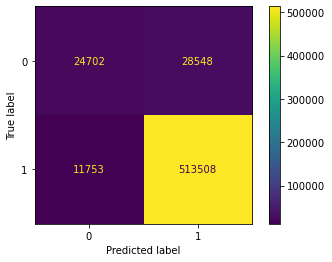

In [65]:
print('accuracy test:', metrics.accuracy_score(y4_test, y4predSV))

print(metrics.classification_report(y4_test, y4predSV))

metrics.plot_confusion_matrix(mSV, X4_test, y4_test)
plt.show()

With the feature DepDelay this model was able to predict perfectly the late and in time/earlier arrivals, now without this feature the model gives a higher quantity of false positives and negatives. The fall in recall, as we had seen in the KNeighbours algorithm, points that the model cannot infer correctly the earlier/in time arrivals, and since we are under the 0.5 we can assume that the model has randomly assigned the 0s and 1s.

Even though, the is able to predict with better accuaracy than the KNeighbours model the late arrivals.

$$\begin{array}{| c | c | c c c c || c | c | c | c | c |}
 &  \mbox{Accuracy} & \mbox{TP}(\%) & \mbox{FP} (\%) & \mbox{FN} (\%) & \mbox{TN} (\%)  & \mbox{Class}  & \mbox{Precision} & \mbox{Recall} & \mbox{F1-score} \\
\hline
\mbox{SVC}  & 0.930 & 4.27 & 4.94 & 2.03 & 88.76 & 0 & 0.68 & 0.46 & 0.55 \\
 & &  &  &  &  & 1 & 0.95 & 0.98 & 0.96 \\
\hline
\end{array}$$

**Summary**

We can see that the models used had loss accuracy in their predictions. The number of false positives and negatives had increased quantitively. All models had loss precision/recall/f1-score in the determination of earlier/in time arrivals, while the late arrivals had been evenly predicted. The best model had been SVC while the worst model is Decision Tree, if we speak in accuracy terms and we do not take into account the number of false positives (recall). Since in our problem we are more interested into late arrivals, the one that is able to give more late arrivals (true negatives) is the SVC, followed by KNeighbours, and finally Decision Tree.

Table summary of the three methods:


$$\begin{array}{| c | c | c c c c || c | c | c | c | c |}
 &  \mbox{Accuracy} & \mbox{TP}(\%) & \mbox{FP} (\%) & \mbox{FN} (\%) & \mbox{TN} (\%)  & \mbox{Class}  & \mbox{Precision} & \mbox{Recall} & \mbox{F1-score} \\
\hline
\mbox{Decision Tree}  & 0.913 & 4.96 & 4.24 & 4.46 & 86.34 & 0 & 0.53 & 0.54 & 0.53 \\
 & &  &  &  &  & 1 & 0.95 & 0.95 & 0.95 \\
\hline
\mbox{KNeighbours}  & 0.913 & 4.46 & 4.75 & 3.36 & 87.43 & 0 & 0.57 & 0.48 & 0.52 \\
 & &  &  &  &  & 1 & 0.95 & 0.96 & 0.96 \\
\hline
\mbox{SVC}  & 0.930 & 4.27 & 4.94 & 2.03 & 88.76 & 0 & 0.68 & 0.46 & 0.55 \\
 & &  &  &  &  & 1 & 0.95 & 0.98 & 0.96 \\
\hline
\end{array}$$